In [1]:
import torch
import huggingface_hub
from utils import *
import argparse
import glob
from os.path import join, exists
import numpy as np

In [2]:
model_imagenet = load_model('dino_imagenet100_vitb14')
model_random = load_model('dino_random_vitb14')


Take key teacher in provided checkpoint dict
Pretrained weights found at /data/alban/models/huggingface_hub/models--eminorhan--dino_imagenet100_vitb14/snapshots/8966196487d102aa7a6bfbdce2e179e4fb1924d6/dino_imagenet100_vitb14.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [3]:
model_imagenet

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

In [5]:
def check_random_initialization(model):
    """Check if model weights appear randomly initialized"""

    results = {}

    for name, param in model.named_parameters():
        if param.requires_grad and len(param.shape) >= 2:  # Focus on weight matrices
            weights = param.data.cpu().numpy().flatten()

            # Calculate statistics
            mean = np.mean(weights)
            std = np.std(weights)

            # Check for common initialization patterns
            is_zero = np.allclose(weights, 0, atol=1e-6)
            is_constant = np.allclose(weights, weights[0], atol=1e-6)

            results[name] = {
                'mean': mean,
                'std': std,
                'min': np.min(weights),
                'max': np.max(weights),
                'is_zero': is_zero,
                'is_constant': is_constant,
                'shape': param.shape
            }

    return results


In [6]:

# Usage
results = check_random_initialization(model_imagenet)

# Print results
for name, stats in results.items():
    print(f"\n{name}:")
    print(f"  Shape: {stats['shape']}")
    print(f"  Mean: {stats['mean']:.6f}")
    print(f"  Std: {stats['std']:.6f}")
    print(f"  Range: [{stats['min']:.6f}, {stats['max']:.6f}]")
    print(f"  All zeros: {stats['is_zero']}")
    print(f"  All same value: {stats['is_constant']}")


cls_token:
  Shape: torch.Size([1, 1, 768])
  Mean: -0.000459
  Std: 0.077931
  Range: [-0.665299, 0.682349]
  All zeros: False
  All same value: False

pos_embed:
  Shape: torch.Size([1, 257, 768])
  Mean: -0.000237
  Std: 0.086909
  Range: [-0.691417, 0.847976]
  All zeros: False
  All same value: False

patch_embed.proj.weight:
  Shape: torch.Size([768, 3, 14, 14])
  Mean: 0.000065
  Std: 0.062588
  Range: [-0.320762, 0.308058]
  All zeros: False
  All same value: False

blocks.0.attn.qkv.weight:
  Shape: torch.Size([2304, 768])
  Mean: -0.000031
  Std: 0.056775
  Range: [-1.709788, 1.175823]
  All zeros: False
  All same value: False

blocks.0.attn.proj.weight:
  Shape: torch.Size([768, 768])
  Mean: -0.000037
  Std: 0.041071
  Range: [-2.840190, 1.787027]
  All zeros: False
  All same value: False

blocks.0.mlp.fc1.weight:
  Shape: torch.Size([3072, 768])
  Mean: -0.000150
  Std: 0.060120
  Range: [-0.882283, 0.762256]
  All zeros: False
  All same value: False

blocks.0.mlp.fc2.

In [8]:
# Usage
results = check_random_initialization(model_random)

# Print results
for name, stats in results.items():
    print(f"\n{name}:")
    print(f"  Shape: {stats['shape']}")
    print(f"  Mean: {stats['mean']:.6f}")
    print(f"  Std: {stats['std']:.6f}")
    print(f"  Range: [{stats['min']:.6f}, {stats['max']:.6f}]")
    print(f"  All zeros: {stats['is_zero']}")
    print(f"  All same value: {stats['is_constant']}")


cls_token:
  Shape: torch.Size([1, 1, 768])
  Mean: 0.000346
  Std: 0.020974
  Range: [-0.068247, 0.067320]
  All zeros: False
  All same value: False

pos_embed:
  Shape: torch.Size([1, 257, 768])
  Mean: 0.000018
  Std: 0.019999
  Range: [-0.090152, 0.086782]
  All zeros: False
  All same value: False

patch_embed.proj.weight:
  Shape: torch.Size([768, 3, 14, 14])
  Mean: -0.000082
  Std: 0.023821
  Range: [-0.041239, 0.041239]
  All zeros: False
  All same value: False

blocks.0.attn.qkv.weight:
  Shape: torch.Size([2304, 768])
  Mean: -0.000005
  Std: 0.020001
  Range: [-0.091095, 0.095015]
  All zeros: False
  All same value: False

blocks.0.attn.proj.weight:
  Shape: torch.Size([768, 768])
  Mean: 0.000015
  Std: 0.019999
  Range: [-0.091601, 0.097139]
  All zeros: False
  All same value: False

blocks.0.mlp.fc1.weight:
  Shape: torch.Size([3072, 768])
  Mean: 0.000008
  Std: 0.020006
  Range: [-0.097556, 0.100708]
  All zeros: False
  All same value: False

blocks.0.mlp.fc2.wei

In [9]:
def plot_weight_distributions(model, max_layers=6):
    """Plot weight distributions for visual inspection"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    layer_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad and len(param.shape) >= 2 and layer_count < max_layers:
            weights = param.data.cpu().numpy().flatten()

            axes[layer_count].hist(weights, bins=50, alpha=0.7)
            axes[layer_count].set_title(f'{name}\nMean: {np.mean(weights):.4f}, Std: {np.std(weights):.4f}')
            axes[layer_count].grid(True, alpha=0.3)

            layer_count += 1

    plt.tight_layout()
    plt.show()

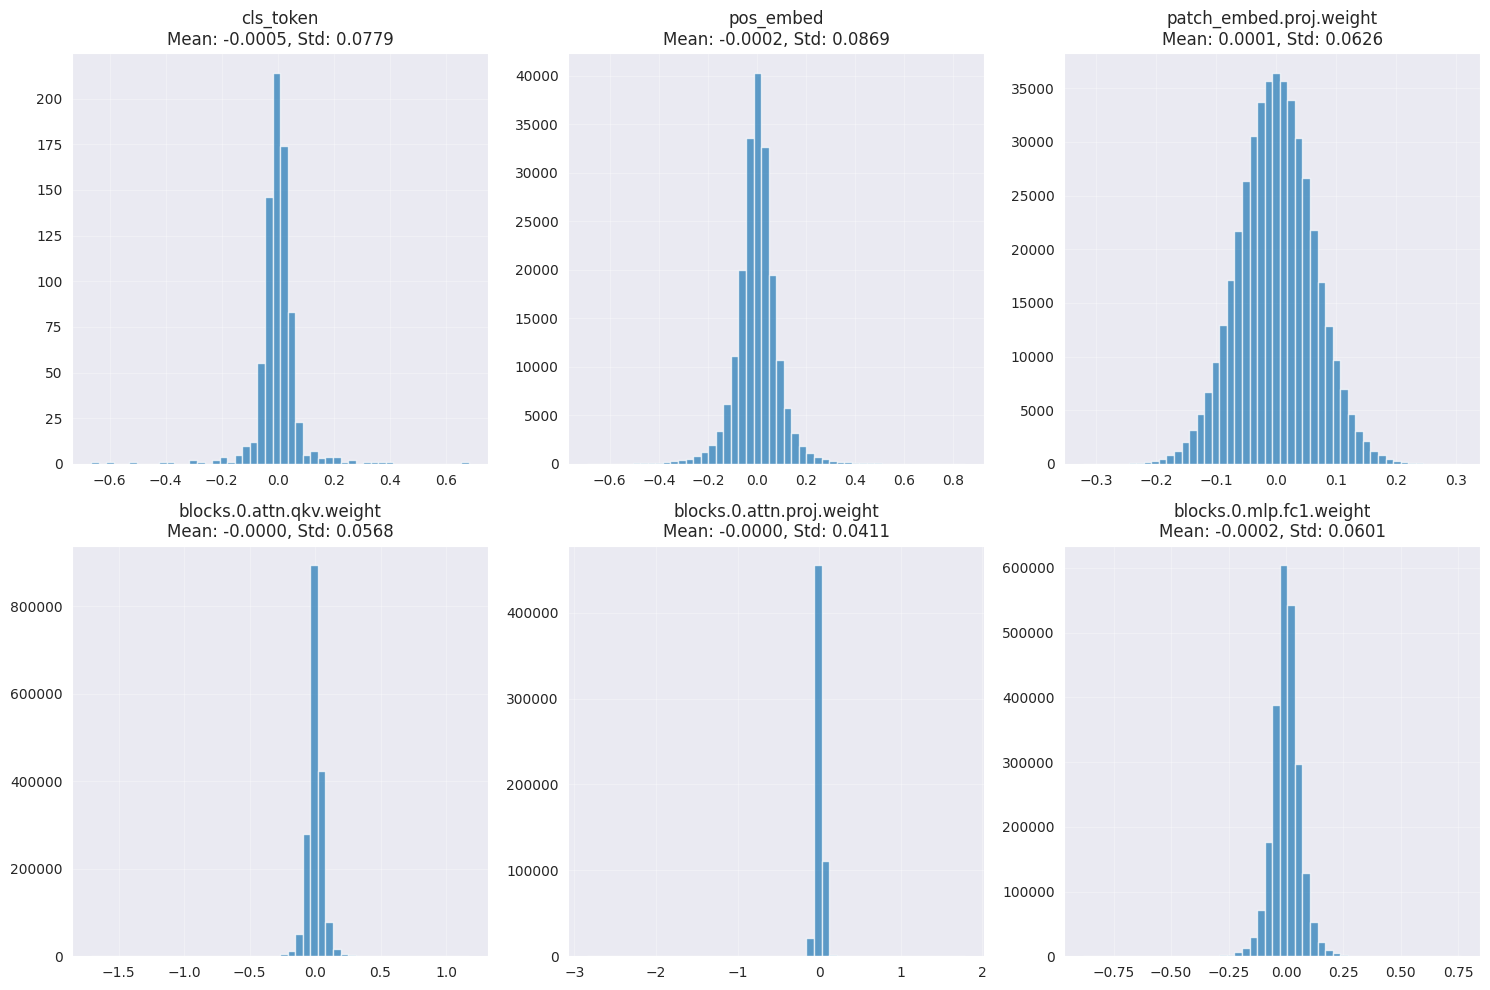

In [10]:
plot_weight_distributions(model_imagenet)

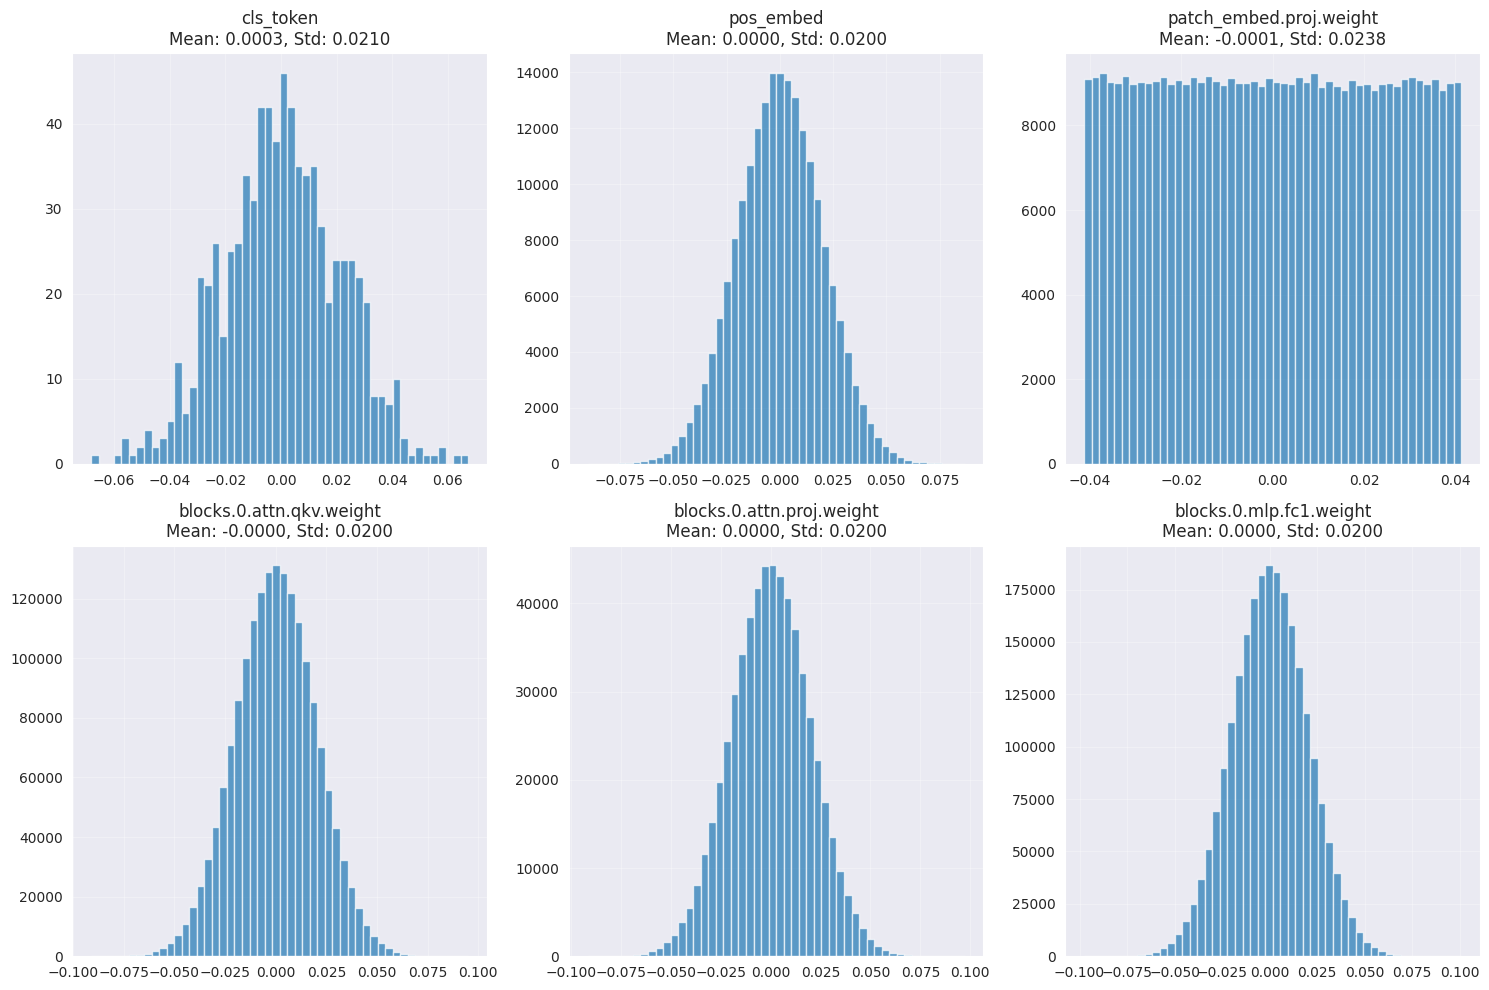

In [11]:
plot_weight_distributions(model_random)